# Linear 2D solution

## Init symbols for *sympy*

In [1]:
from sympy import *
from geom_util import *
from sympy.vector import CoordSys3D
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

%matplotlib inline

%reload_ext autoreload
%autoreload 2
%aimport geom_util

In [2]:
# Any tweaks that normally go in .matplotlibrc, etc., should explicitly go here
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = (12, 12)

plt.rc('text', usetex=True)
    
plt.rc('font', family='serif')

init_printing()

In [3]:
N = CoordSys3D('N')
alpha1, alpha2, alpha3 = symbols("alpha_1 alpha_2 alpha_3", real = True, positive=True)
A,K,rho = symbols("A K rho")

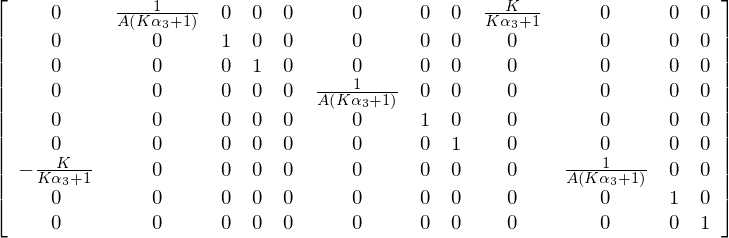

In [4]:
B=Matrix([[0, 1/(A*(K*alpha3 + 1)), 0, 0, 0, 0, 0, 0, K/(K*alpha3 + 1), 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1/(A*(K*alpha3 + 1)), 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [-K/(K*alpha3 + 1), 0, 0, 0, 0, 0, 0, 0, 0, 1/(A*(K*alpha3 + 1)), 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
B

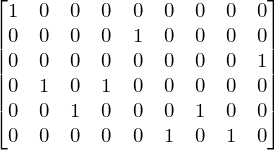

In [5]:
E=zeros(6,9)
E[0,0]=1
E[1,4]=1
E[2,8]=1
E[3,1]=1
E[3,3]=1
E[4,2]=1
E[4,6]=1
E[5,5]=1
E[5,7]=1
E

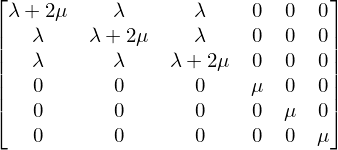

In [6]:
mu = Symbol('mu')
la = Symbol('lambda')
C_tensor = getIsotropicStiffnessTensor(mu, la)
C = convertStiffnessTensorToMatrix(C_tensor)
C

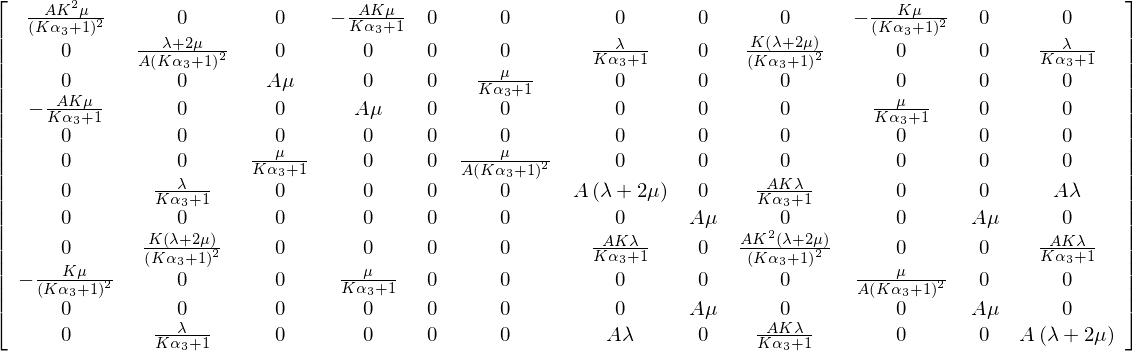

In [7]:
S=B.T*E.T*C*E*B*A#*(1+alpha3*K)
S

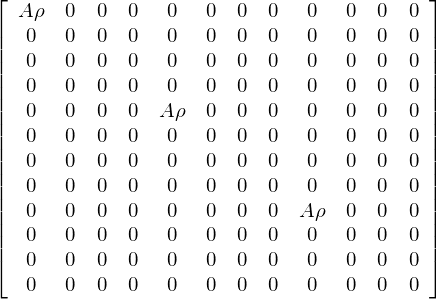

In [8]:
M=Matrix([[rho, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, rho, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, rho, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
M=M*A#*(1+alpha3*K)
M

## Cartesian coordinates

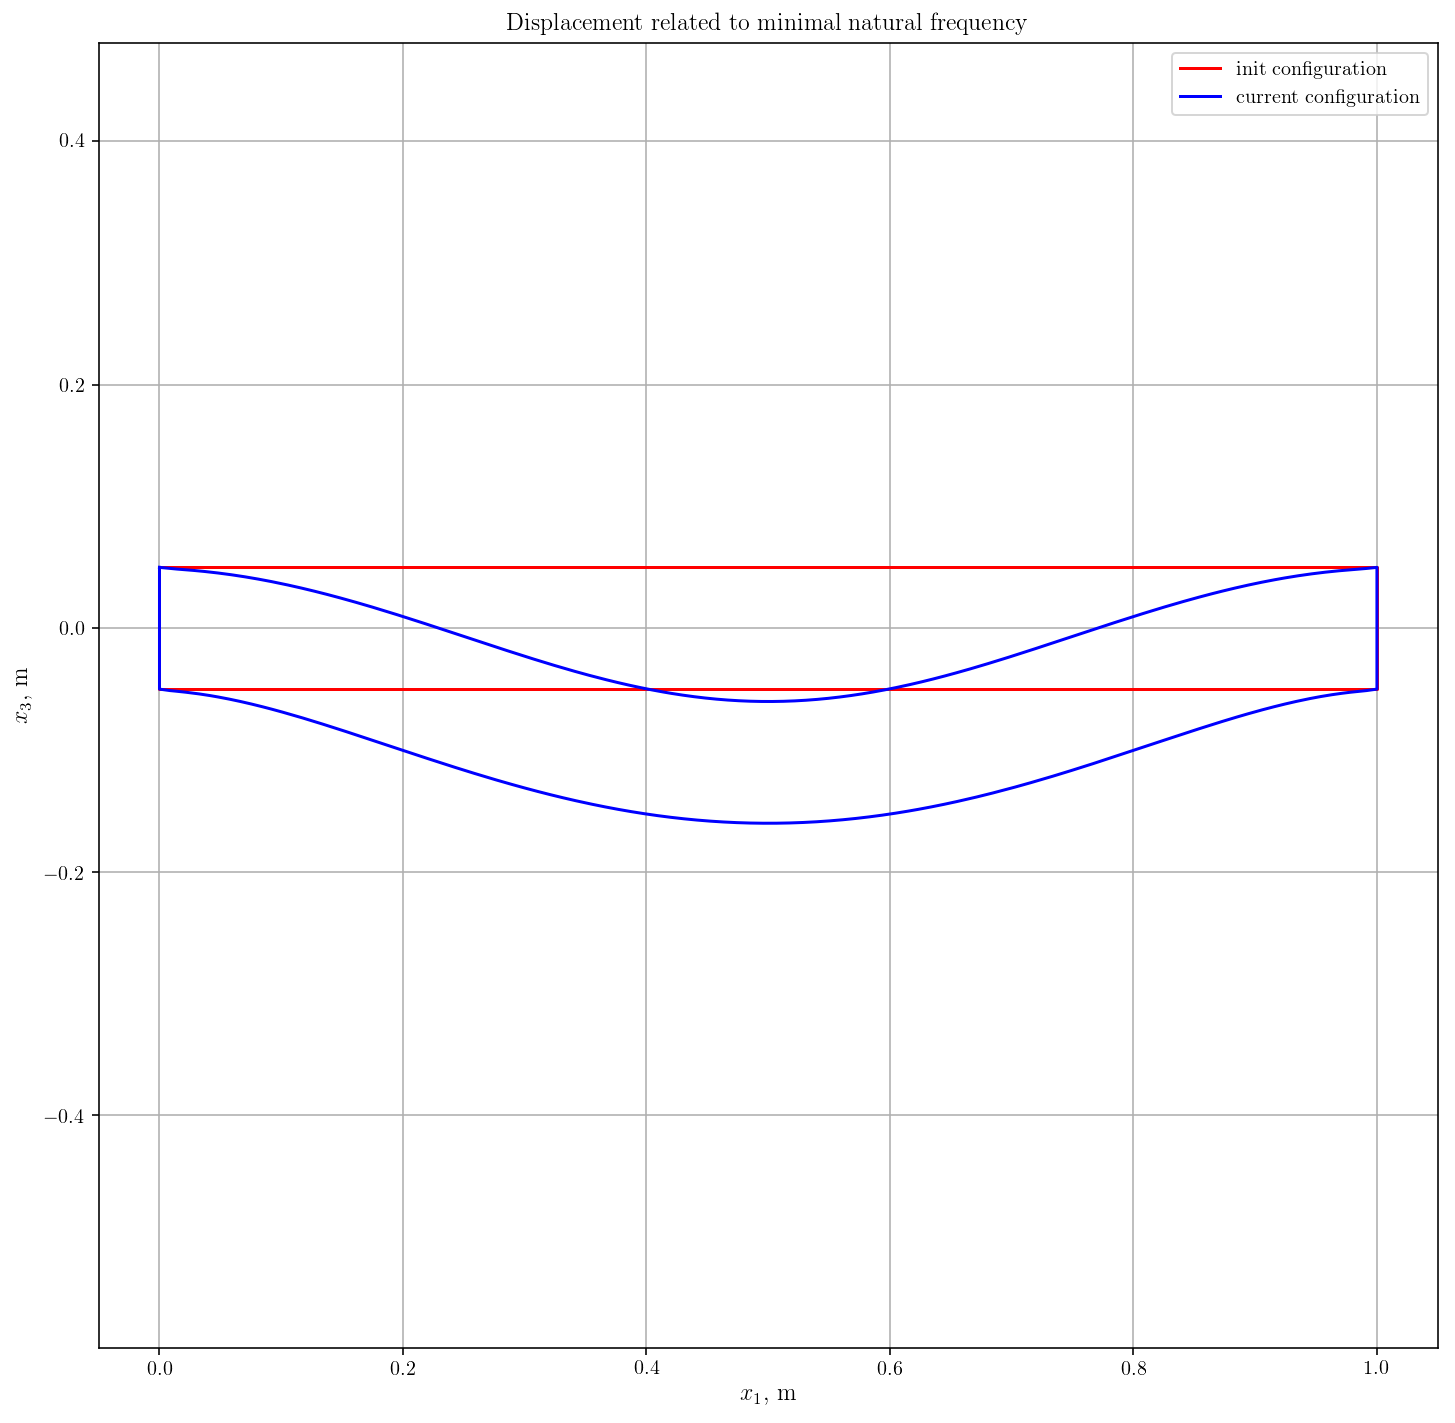

453.798788035
1160.1988298
2093.45369056
2354.84806595
3175.79383041
4359.61899348
4700.13424088
5613.60908408
6917.36504982
7024.50688986
8256.83170056
9312.47399689
9621.93241242
11004.9842264
11540.7926103
12399.4188672
13672.9091004
13788.0391184
14176.2048473
14790.7763272


In [9]:
import fem.geometry as g
import fem.model as m
import fem.material as mat
import fem.mesh as me
import plot

import fem.general2D.solverlinear as s2D
import fem.general2D.result2D as r2D

def solve2D(geometry, thickness, material, N, M):
    layers = m.Layer.generate_layers(thickness, [material])
    model = m.Model(geometry, layers, m.Model.FIXED_LEFT_RIGHT_EDGE)
    mesh = me.Mesh.generate2D(geometry.width, layers, N, M, model.boundary_conditions)
    
    lam, vec = s2D.solve(model, mesh, stiffness_matrix, mass_matrix)
    
    results = r2D.Result.convert_to_results(lam, vec, mesh, geometry)
    
    return results

stiffness_matrix_func = lambdify([A, K, mu, la, alpha3], S, "numpy")
mass_matrix_func = lambdify([A, K, rho, alpha3], M, "numpy")


def stiffness_matrix(material, geometry, x1, x2, x3):
    A,K = geometry.get_A_and_K(x1,x2,x3)
    return stiffness_matrix_func(A, K, material.mu(), material.lam(), x3)

def mass_matrix(material, geometry, x1, x2, x3):
    A,K = geometry.get_A_and_K(x1,x2,x3)
    return mass_matrix_func(A, K, material.rho, x3)


E3f = 1000000000
material = mat.IsotropicMaterial(40000000000,0.3,2000)
material.C[2,2] *= E3f

width = 1
curvature = 0
thickness = 0.1

corrugation_amplitude = 0
corrugation_frequency = 0

geometry = g.General(width, curvature, corrugation_amplitude, corrugation_frequency)

N_width = 100
N_height = 10


results = solve2D(geometry, thickness, material, N_width, N_height)

results_index = 0

# plot.plot_deformed_mesh(results[results_index], width, thickness)
    
plot.plot_init_and_deformed_geometry_in_cartesian(results[results_index], 0, width, -thickness / 2, thickness / 2, 0, geometry.to_cartesian_coordinates)    
    
to_print = 20
if (len(results) < to_print):
    to_print = len(results)

for i in range(to_print):
    print(results[i].freqHz())
    
# print(results[results_index].get_displacement_and_deriv(0, 0, -thickness/2, 0, True))


In [10]:
print(results[results_index].get_displacement_and_deriv(0, 0, -thickness/2, 0, True))

x1 = 0, x3 = -0.05
Element(tl=909,tr=910,br=1011,bl=1010)
[ 0.         -0.15224819  0.          0.          0.          0.          0.
  0.          0.         -0.11907886  0.          0.        ]
